In [1]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

# from alpha_vantage import alpha_vantage.timeseries
from alpha_vantage.timeseries import TimeSeries
api_key = 'S7MZO4XSG71DN2NB'

import os
import tensorflow as tf

Using TensorFlow backend.


In [2]:
ts = TimeSeries(key=api_key,output_format='pandas')
ticker = 'NASDAQ:INTC'

In [3]:
# Get the raw dataset
orig_dataset, meta_df = ts.get_daily(symbol=ticker, outputsize='full')

In [4]:
orig_dataset.columns = ['open', 'high', 'low', 'close', 'volume']
orig_dataset.head(3)
orig_dataset.shape

(5032, 5)

In [5]:
# Data cleaning
print('Checking for null values')
orig_dataset.isna().any()

Checking for null values


open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [6]:
# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

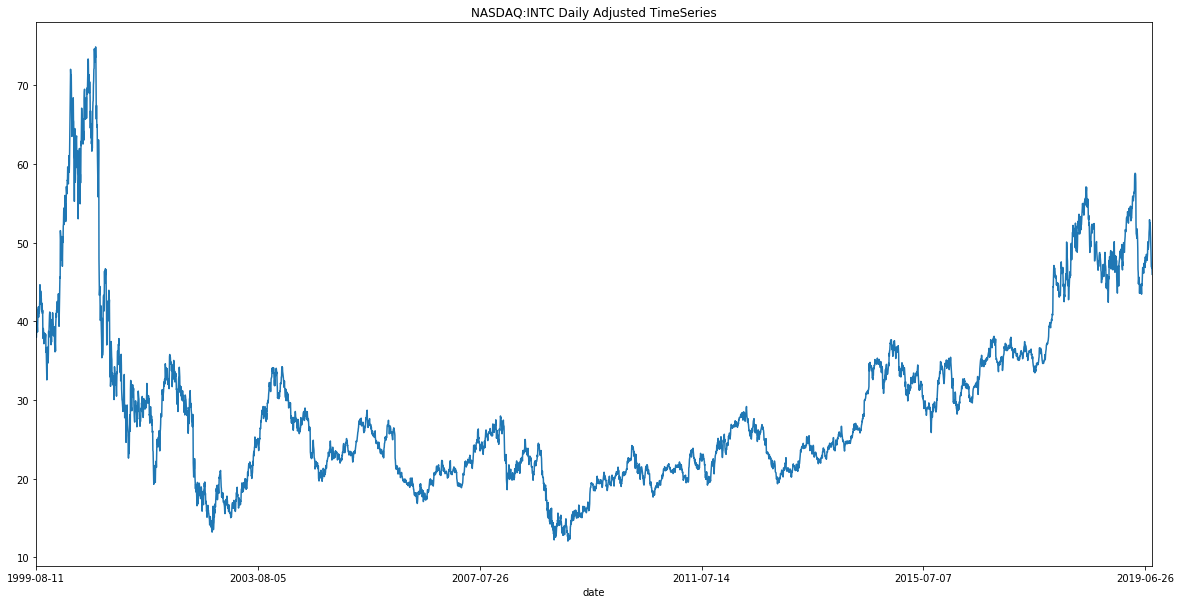

In [7]:
# plot the dataset
orig_dataset['close'].plot()
plt.title(f'{ticker} Daily Adjusted TimeSeries')
plt.show()

In [8]:
# Look at volume
#plt.figure()
#plt.plot(dataset["volume"])
#plt.title(f'{ticker} stock volume history')
#plt.ylabel('Volume')
#plt.xlabel('Days')
#plt.show()

In [9]:
# Create data frame tu use to extract traing, test data
df = orig_dataset['close'].values
df = df.reshape(-1,1)
print(df.shape)


(5032, 1)


In [10]:
orig_dataset['close'].tail(10)

date
2019-07-29    52.51
2019-07-30    51.70
2019-07-31    50.55
2019-08-01    49.50
2019-08-02    48.68
2019-08-05    46.97
2019-08-06    46.96
2019-08-07    46.73
2019-08-08    47.17
2019-08-09    45.98
Name: close, dtype: float64

In [11]:
arr = np.array(df[:-11:-1])
reversed_arr = arr[::-1]
reversed_arr

array([[52.51],
       [51.7 ],
       [50.55],
       [49.5 ],
       [48.68],
       [46.97],
       [46.96],
       [46.73],
       [47.17],
       [45.98]])

In [12]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-60:])
print(dataset_train.shape)
print(dataset_test.shape)

(4025, 1)
(1067, 1)


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:7]

array([[0.41277172],
       [0.41227486],
       [0.44263078],
       [0.43317621],
       [0.43665897],
       [0.43267776],
       [0.42322319]])

In [14]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:7]

array([[0.3329883 ],
       [0.33967673],
       [0.33553627],
       [0.33903973],
       [0.3419062 ],
       [0.34031372],
       [0.33474003]])

In [15]:
# converting dataset into x_train and y_train
def create_dataset(df):
    x = []
    y = []
    for i in range(60,df.shape[0]):
        x.append(df[i-60:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [16]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.41277172, 0.41227486, 0.44263078, 0.43317621, 0.43665897,
        0.43267776, 0.42322319, 0.44412453, 0.46801178, 0.46950394,
        0.4739836 , 0.45308225, 0.46850864, 0.46253683, 0.46203997,
        0.47199299, 0.48692253, 0.5187722 , 0.50533482, 0.49189904,
        0.50633012, 0.50334422, 0.47945696, 0.49090373, 0.46850864,
        0.46552273, 0.48144757, 0.4769695 , 0.46054622, 0.46701648,
        0.42471534, 0.41015845, 0.4301903 , 0.42471534, 0.40630305,
        0.39933593, 0.40431245, 0.42073413, 0.41426547, 0.42023728,
        0.40978581, 0.41028426, 0.41675293, 0.41824668, 0.38191735,
        0.39162194, 0.37196433, 0.3600207 , 0.32618043, 0.36450036,
        0.37843459, 0.39236882, 0.37495023, 0.37644398, 0.36051915,
        0.3824158 , 0.42421849, 0.41277172, 0.42471534, 0.44263078]])

In [17]:
y_train[:1]

array([0.45706346])

In [18]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.3329883 , 0.33967673, 0.33553627, 0.33903973, 0.3419062 ,
        0.34031372, 0.33474003, 0.34445418, 0.34923163, 0.3563978 ,
        0.34763914, 0.33744725, 0.32884784, 0.32215941, 0.31467474,
        0.30607532, 0.30527908, 0.31435624, 0.31483398, 0.30639382,
        0.30750856, 0.31148977, 0.31642647, 0.32327415, 0.31833745,
        0.32136317, 0.31865594, 0.31578947, 0.31706346, 0.30161637,
        0.29158372, 0.29206147, 0.28823951, 0.29429095, 0.28601003,
        0.28378056, 0.27741062, 0.26833347, 0.27215543, 0.28107333,
        0.27979935, 0.28043634, 0.28378056, 0.27693288, 0.27104069,
        0.26498925, 0.26323752, 0.26307827, 0.25447886, 0.25909706,
        0.26881121, 0.26960745, 0.26801497, 0.26865196, 0.27024445,
        0.27151843, 0.27135918, 0.26960745, 0.26753722, 0.2796401 ]])

In [19]:
#reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(3965, 60, 1)
(1007, 60, 1)


In [20]:
tf.logging.set_verbosity(tf.logging.ERROR)
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total para

In [22]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [23]:
if(not os.path.exists('./outputs/stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=100, batch_size=32)
    model.save('./outputs/stock_prediction.h5')
else:
    model = load_model('./outputs/stock_prediction.h5')
    

Epoch 1/100
3965/3965 [==============================] - 9s 2ms/step - loss: 0.0144
Epoch 2/100
3965/3965 [==============================] - 8s 2ms/step - loss: 0.0018
Epoch 3/100
3965/3965 [==============================] - 9s 2ms/step - loss: 0.0014
Epoch 4/100
3965/3965 [==============================] - 9s 2ms/step - loss: 0.0012
Epoch 5/100
3965/3965 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 6/100
3965/3965 [==============================] - 9s 2ms/step - loss: 9.8889e-04
Epoch 7/100
3965/3965 [==============================] - 9s 2ms/step - loss: 9.7334e-04
Epoch 8/100
3965/3965 [==============================] - 9s 2ms/step - loss: 8.3076e-04
Epoch 9/100
3965/3965 [==============================] - 9s 2ms/step - loss: 8.4011e-04
Epoch 10/100
3965/3965 [==============================] - 9s 2ms/step - loss: 8.3038e-04
Epoch 11/100
3965/3965 [==============================] - 9s 2ms/step - loss: 7.9318e-04
Epoch 12/100
3965/3965 [==========================

3965/3965 [==============================] - 9s 2ms/step - loss: 2.8664e-04
Epoch 94/100
3965/3965 [==============================] - 9s 2ms/step - loss: 3.1415e-04
Epoch 95/100
3965/3965 [==============================] - 9s 2ms/step - loss: 3.2485e-04
Epoch 96/100
3965/3965 [==============================] - 9s 2ms/step - loss: 2.6475e-04
Epoch 97/100
3965/3965 [==============================] - 9s 2ms/step - loss: 2.8149e-04
Epoch 98/100
3965/3965 [==============================] - 9s 2ms/step - loss: 3.0096e-04
Epoch 99/100
3965/3965 [==============================] - 9s 2ms/step - loss: 2.7625e-04
Epoch 100/100
3965/3965 [==============================] - 9s 2ms/step - loss: 2.9687e-04


OSError: Unable to create file (unable to open file: name = './outputs/stock_prediction.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [24]:
!pwd

/home/jmpichar/edu/bcs/homework/project-3-ml/v2


In [ ]:
x_test

In [ ]:
# visualize the predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df, color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='predicted')

plt.legend()

In [ ]:
orig_dataset.tail(10)

In [ ]:
orig_dataset.info()

In [ ]:
orig_arr = np.array(df[:-11:-1])
orig_reversed_arr = orig_arr[::-1]
orig_reversed_arr

In [ ]:
pred_arr = np.array(predictions[:-11:-1])
pred_reversed_arr = pred_arr[::-1]
pred_reversed_arr

In [ ]:
# percentdiff = ((val1-val2)/((val1+val2)/2))*100
# percentdiff

In [ ]:
new_df = orig_dataset.copy()
new_df = new_df.reset_index()
new_df.shape

In [ ]:
new_df = new_df.iloc[-10:]
new_df.shape

In [ ]:
new_df = new_df[['date','close']]


In [ ]:
#new_df.set_index('date', inplace=True)

In [ ]:
new_df

In [ ]:
tmp_date = new_df['date']
tmp_date

In [ ]:
new_df.info()

In [ ]:
#data = {'actual close':orig_reversed_arr, 'predicted close':pred_reversed_arr}

percent_diff = pd.DataFrame({'close':orig_reversed_arr[:,0], 'pred':pred_reversed_arr[:,0]})

In [ ]:
mask = ((percent_diff['close'] - percent_diff['pred']) / ((percent_diff['close'] + percent_diff['pred'])/2))*100
mask
percent_diff['percent difference'] = mask.round(2)
percent_diff

In [ ]:
((46.970-50.077579)/((46.970+50.077579)/2))*100

In [ ]:
new_df.merge(percent_diff, on='close').set_index('date')